In [2]:
%pip uninstall -y qiskit qiskit-terra qiskit-aer qiskit_experiments qiskit_iqm qiskit-ibm-runtime iqm-client
%pip install qiskit qiskit-aer==0.15.1 qiskit-ibm-runtime qiskit_experiments
%pip install cvxpy matplotlib pylatexenc
%pip install iqm-client[qiskit]

from IPython.display import clear_output

clear_output()

Questo notebook si basa sui concetti e sulle metodologie presentati nel paper Protecting quantum memories using coherent parity check codes, reperibile al seguente [link](https://arxiv.org/pdf/1709.01866). Le tecniche implementati in questo notebook sono ispirati dalle formulazioni teoriche e dai risultati discussi in tale lavoro.

## Simulazione Noisless

In questa sezione, si effettua un confronto tra lo stato iniziale ∣+0⟩ senza encoding e con l'encoding [[4,2,2]]. La simulazione viene eseguita utilizzando il backend Aer (nessun modello di noise applicato), con la coupling map di IQM Spark.

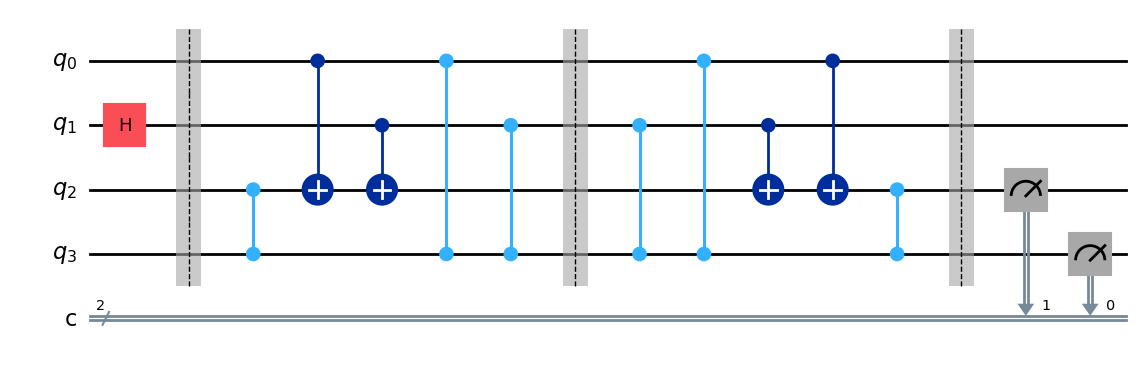

In [5]:
#Creazione del circuito con l'encoding (stato iniziale: |+0>)
from qiskit import QuantumCircuit, transpile

qc_with_encoding = QuantumCircuit(4, 2)
qc_with_encoding.h(1)
qc_with_encoding.barrier()
qc_with_encoding.cz(2, 3)
qc_with_encoding.cx(0, 2)
qc_with_encoding.cx(1, 2)
qc_with_encoding.cz(0, 3)
qc_with_encoding.cz(1, 3)
qc_with_encoding.barrier()
qc_with_encoding.cz(1, 3)
qc_with_encoding.cz(0, 3)
qc_with_encoding.cx(1, 2)
qc_with_encoding.cx(0, 2)
qc_with_encoding.cz(2, 3)
qc_with_encoding.barrier()
qc_with_encoding.measure(2, 1)
qc_with_encoding.measure(3, 0)
qc_with_encoding.draw('mpl')


Nella cella successiva, si esegue il circuito utilizzando il simulatore Aer e la coupling map di IQM Spark. Il mapping ottimale viene determinato automaticamente, con l'ottimizzazione garantita dal routing method SABRE.

In [6]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from iqm.qiskit_iqm import IQMProvider

#Transpilazione con Aer simulator e con coupling map di IQM Spark

# Connessione a IQM
iqm_server_url = "https://cocos.resonance.meetiqm.com/pyrite:test"
token = '5NfbyPAwHoGXfeFE511HzXjq3tVkQDi5xXKKyPA2VpcGflM3c2t5CYAAxkmzp22q'

provider = IQMProvider(iqm_server_url, token=token)
backend = provider.get_backend()

# Informazioni necessarie dal backend reale
iqm_basis_gates = backend.operation_names
iqm_coupling_map = backend.coupling_map

print(qc_with_encoding)

simulator = AerSimulator()
qc_coded = transpile(qc_with_encoding, simulator, coupling_map=iqm_coupling_map,
                     routing_method="sabre", optimization_level=0)

result = simulator.run(qc_coded).result()
counts = result.get_counts()
print(qc_coded)
print("Syndrome: ", counts)

#Step 4: Calcolo del numero di SWAP gates
swap_count = qc_coded.count_ops().get('swap', 0)
print("Numero di SWAP nel circuito transpilato con l'encoding: ", swap_count)

c:\Users\franc\anaconda3\Lib\site-packages\iqm\iqm_client\iqm_client.py:142: UserWarning: Your IQM Client version 23.6 was built for a different version of IQM Server. You might encounter issues. For the best experience, consider using a version of IQM Client that satisfies 22.3 <= iqm-client < 23.0.
  warnings.warn(version_incompatibility_msg)


           ░                     ░                     ░       
q_0: ──────░──────■────────■─────░─────■────────■──────░───────
     ┌───┐ ░      │        │     ░     │        │      ░       
q_1: ┤ H ├─░──────┼────■───┼──■──░──■──┼───■────┼──────░───────
     └───┘ ░    ┌─┴─┐┌─┴─┐ │  │  ░  │  │ ┌─┴─┐┌─┴─┐    ░ ┌─┐   
q_2: ──────░──■─┤ X ├┤ X ├─┼──┼──░──┼──┼─┤ X ├┤ X ├─■──░─┤M├───
           ░  │ └───┘└───┘ │  │  ░  │  │ └───┘└───┘ │  ░ └╥┘┌─┐
q_3: ──────░──■────────────■──■──░──■──■────────────■──░──╫─┤M├
           ░                     ░                     ░  ║ └╥┘
c: 2/═════════════════════════════════════════════════════╩══╩═
                                                          1  0 
                     ░                        ░                        ░       
      q_0 -> 0 ──────░──────■───────────■─────░─────■───────────■──────░───────
               ┌───┐ ░      │           │     ░     │           │      ░       
      q_1 -> 1 ┤ H ├─░──────┼────■──────┼──■──░──■──┼───

Nella cella successiva, invece, si imposta manualmente il mapping iniziale e si utilizza l'algoritmo BFS per verificare che il numero minimo di SWAP necessari per eseguire il circuito sulla coupling map di IQM Spark sia 2. Dopo aver testato diverse assegnazioni, si conferma che il valore minimo effettivo è 2. Se il transpiler inserisce un numero maggiore di SWAP, significa che il mapping o il routing non sono ottimali.

In [7]:
from collections import deque

# Costruzione del grafo
def build_graph(coupling_map):
    graph = {}
    for edge in coupling_map.get_edges():
        q1, q2 = edge
        if q1 not in graph:
            graph[q1] = []
        graph[q1].append(q2)
    return graph

# BFS per trovare il percorso minimo tra due qubit
def bfs_path(graph, start, goal):
    queue = deque([(start, [start])])
    visited = set()

    while queue:
        node, path = queue.popleft()
        if node == goal:
            return path
        if node not in visited:
            visited.add(node)
            for neighbor in graph.get(node, []):
                queue.append((neighbor, path + [neighbor]))

    return None  # Nessun percorso trovato

# Costruzione del grafo della coupling map
iqm_graph = build_graph(iqm_coupling_map)

# Assegnazione intelligente
qubit_centrale = 2  # Il nodo centrale della topologia a stella
qubit_periferici = [0, 1, 3]  # I qubit connessi al nodo centrale

mapping = {
    "A": qubit_periferici[0],  # Secondo nodo periferico
    "B": qubit_periferici[1],  #  Primo nodo periferico
    "p1": qubit_centrale,      # Il qubit centrale viene assegnato a p1
    "p2": qubit_periferici[2]  # Terzo nodo periferico
}

print("Mappatura assegnata:", mapping)

# Verifica dei percorsi minimi tra i qubit usati nel circuito
for q1, q2 in [(mapping["A"], mapping["p2"]), (mapping["B"], mapping["p2"]),
               (mapping["A"], mapping["p1"]), (mapping["B"], mapping["p1"]),
               (mapping["p1"], mapping["p2"])]:
    path = bfs_path(iqm_graph, q1, q2)
    print(f"Percorso tra {q1} e {q2}: {path}")

#Transpilazione con il layout definito prima
initial_layout = [mapping["A"], mapping["B"], mapping["p1"], mapping["p2"]]
qc_optimized = transpile(qc_with_encoding, simulator,
                         coupling_map=iqm_coupling_map,
                         routing_method="sabre",
                         initial_layout=initial_layout,
                         optimization_level=0)
results = simulator.run(qc_optimized).result()
counts = results.get_counts()
print("Syndrome: ", counts)

swap_count_optimized = qc_optimized.count_ops().get('swap', 0)
print("Numero di SWAP dopo l'ottimizzazione:", swap_count_optimized)


print(qc_optimized)

Mappatura assegnata: {'A': 0, 'B': 1, 'p1': 2, 'p2': 3}
Percorso tra 0 e 3: [0, 2, 3]
Percorso tra 1 e 3: [1, 2, 3]
Percorso tra 0 e 2: [0, 2]
Percorso tra 1 e 2: [1, 2]
Percorso tra 2 e 3: [2, 3]
Syndrome:  {'00': 1024}
Numero di SWAP dopo l'ottimizzazione: 2
                     ░                        ░                        ░       
      q_0 -> 0 ──────░──────■───────────■─────░─────■───────────■──────░───────
               ┌───┐ ░      │           │     ░     │           │      ░       
      q_1 -> 1 ┤ H ├─░──────┼────■──────┼──■──░──■──┼──────■────┼──────░───────
               └───┘ ░    ┌─┴─┐┌─┴─┐    │  │  ░  │  │    ┌─┴─┐┌─┴─┐    ░    ┌─┐
      q_2 -> 2 ──────░──■─┤ X ├┤ X ├─X──■──■──░──■──■──X─┤ X ├┤ X ├─■──░────┤M├
                     ░  │ └───┘└───┘ │        ░        │ └───┘└───┘ │  ░ ┌─┐└╥┘
      q_3 -> 3 ──────░──■────────────X────────░────────X────────────■──░─┤M├─╫─
                     ░                        ░                        ░ └╥┘ ║ 
ancilla_0 -> 4 ────

Di seguito viene eseguita la Quantum State Tomography per ricostruire lo stato iniziale. In prima fase, si effettua la tomografia sui data qubits per ottenere lo stato finale ricostruito e si calcola la fidelity tra questo stato e lo stato uncoded |+0> (in assenza di noise, lo stato iniziale dovrebbe essere protetto, senza errori). Per la ricostruzione dello stato, vengono utilizzate due metodologie di fitting: Linear Inversion (metodo predefinito) e cvxpy_gaussian_lstsq.

In [8]:
import numpy as np
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.visualization import plot_state_city
import cvxpy

import warnings
warnings.filterwarnings("ignore")

def run_tomography_and_reconstruct(qst_circuit, backend, num_repetitions=2):
    density_matrices = {"linear": [], "cvx": []}
    fidelities = {"linear": [], "cvx": []}
    purity_values = {"linear": [], "cvx": []}  # Liste per memorizzare i valori di purezza
    ideal_state = DensityMatrix.from_label("+0")

    for _ in range(num_repetitions):
        qst_exp = StateTomography(qst_circuit, measurement_indices=[0, 1])
        qst_data = qst_exp.run(backend, shots=8192).block_for_results()

        # Ricostruzione con Linear Inversion
        rho_full_linear = qst_data.analysis_results("state", dataframe=True).iloc[0]["value"]
        density_matrices["linear"].append(rho_full_linear)
        fidelities["linear"].append(state_fidelity(rho_full_linear, ideal_state))

        # Calcolare la purezza per la Linear Inversion
        rho_linear = DensityMatrix(rho_full_linear)
        purity_linear = np.trace(rho_linear.data @ rho_linear.data).real
        purity_values["linear"].append(purity_linear)

        # Ricostruzione con CVX
        try:
            qst_exp.analysis.set_options(fitter='cvxpy_gaussian_lstsq')
            qst_data_cvx = qst_exp.run(backend, shots=8192).block_for_results()
            rho_full_cvx = qst_data_cvx.analysis_results("state", dataframe=True).iloc[0]["value"]
            density_matrices["cvx"].append(rho_full_cvx)
            fidelities["cvx"].append(state_fidelity(rho_full_cvx, ideal_state))

            # Calcolare la purezza per CVX
            rho_cvx = DensityMatrix(rho_full_cvx)
            purity_cvx = np.trace(rho_cvx.data @ rho_cvx.data).real
            purity_values["cvx"].append(purity_cvx)

        except ModuleNotFoundError:
            print("CVXPY non installato.")
            break

    # Media delle density matrices ottenute con tutte le basi
    avg_density_matrix_linear = np.mean(np.array(density_matrices["linear"], dtype=object), axis=0)
    plot_state_city(avg_density_matrix_linear, title="Average Density Matrix (Linear Inversion) for the data qubits").savefig("DQ_avg_density_matrix_linear_NOISLESS.png")

    if density_matrices["cvx"]:
        avg_density_matrix_cvx = np.mean(np.array(density_matrices["cvx"], dtype=object), axis=0)
        plot_state_city(avg_density_matrix_cvx, title="Average Density Matrix (CVX) for the data qubits").savefig("DQ_avg_density_matrix_cvx_NOISLESS.png")

    # Calcolo media e deviazione standard delle fidelity
    mean_fid_linear, std_fid_linear = np.mean(fidelities["linear"]), np.std(fidelities["linear"])
    mean_fid_cvx, std_fid_cvx = (np.mean(fidelities["cvx"]), np.std(fidelities["cvx"])) if fidelities["cvx"] else (None, None)

    # Calcolo media e deviazione standard della purezza
    mean_purity_linear, std_purity_linear = np.mean(purity_values["linear"]), np.std(purity_values["linear"])
    mean_purity_cvx, std_purity_cvx = (np.mean(purity_values["cvx"]), np.std(purity_values["cvx"])) if purity_values["cvx"] else (None, None)

    return density_matrices, fidelities, mean_fid_linear, std_fid_linear, mean_fid_cvx, std_fid_cvx, mean_purity_linear, std_purity_linear, mean_purity_cvx, std_purity_cvx

density_matrices, fidelities, mean_fid_linear, std_fid_linear, mean_fid_cvx, std_fid_cvx, mean_purity_linear, std_purity_linear, mean_purity_cvx, std_purity_cvx = run_tomography_and_reconstruct(qc_optimized, simulator)

# Risultati della fidelity
print(f"Fidelity media (Linear Inversion): {mean_fid_linear:.10f} ± {std_fid_linear:.10f}")
if mean_fid_cvx is not None:
    print(f"Fidelity media (CVX): {mean_fid_cvx:.10f} ± {std_fid_cvx:.10f}")
else:
    print("Nessun risultato di CVX.")

# Risultati della purezza
print(f"Purity media (Linear Inversion): {mean_purity_linear:.10f} ± {std_purity_linear:.10f}")
if mean_purity_cvx is not None:
    print(f"Purity media (CVX): {mean_purity_cvx:.10f} ± {std_purity_cvx:.10f}")
else:
    print("Nessun risultato di CVX.")


Fidelity media (Linear Inversion): 0.9974989164 ± 0.0002627268
Fidelity media (CVX): 0.9999441259 ± 0.0000146954
Purity media (Linear Inversion): 0.9951426213 ± 0.0005272794
Purity media (CVX): 0.9999876544 ± 0.0000006826


## Simulazione con il Noise

In questa sezione, si effettua un confronto tra lo stato iniziale ∣+0⟩ senza encoding e con l'encoding [[4,2,2]]. La simulazione viene eseguita utilizzando il fake backend Anodis che presenta un modello di rumore non troppo dissimile da quello di IQM Spark. Si ripetono gli stessi passaggi della sezione precedente.

In [9]:
from iqm.qiskit_iqm.fake_backends.fake_adonis import IQMFakeAdonis
alternative_simulator = IQMFakeAdonis()
error_profile = alternative_simulator.error_profile
print(error_profile)

IQMErrorProfile(t1s={'QB1': 27000.0, 'QB2': 33000.0, 'QB3': 25000.0, 'QB4': 40000.0, 'QB5': 25000.0}, t2s={'QB1': 20000.0, 'QB2': 26000.0, 'QB3': 23000.0, 'QB4': 26000.0, 'QB5': 7000.0}, single_qubit_gate_depolarizing_error_parameters={'prx': {'QB1': 0.0006, 'QB2': 0.0054, 'QB3': 0.0001, 'QB4': 0.0, 'QB5': 0.0005}}, two_qubit_gate_depolarizing_error_parameters={'cz': {('QB1', 'QB3'): 0.0335, ('QB2', 'QB3'): 0.0344, ('QB3', 'QB4'): 0.0192, ('QB3', 'QB5'): 0.0373}}, single_qubit_gate_durations={'prx': 40.0}, two_qubit_gate_durations={'cz': 80.0}, readout_errors={'QB1': {'0': 0.021, '1': 0.021}, 'QB2': {'0': 0.018, '1': 0.018}, 'QB3': {'0': 0.056, '1': 0.056}, 'QB4': {'0': 0.021, '1': 0.021}, 'QB5': {'0': 0.023, '1': 0.023}}, name='sample-chip')


In [ ]:
from qiskit_aer.noise import NoiseModel

# Ottieni il modello di rumore dal FakeBackend
noise_model = alternative_simulator.noise_model

# Crea un simulatore con il modello di rumore
noisy_simulator = AerSimulator(noise_model=noise_model, basis_gates=noise_model.basis_gates)

# Transpilare il circuito con il set di gate e la coupling map di IQM
transpiled_circuit = transpile(qc_with_encoding,
    optimization_level=0,
    backend=noisy_simulator,
    basis_gates=iqm_basis_gates,
    coupling_map=iqm_coupling_map,
    routing_method="sabre")

# Conta il numero di operazioni SWAP nel circuito traspolato
swap_count_optimized = transpiled_circuit.count_ops().get('swap', 0)
print("Numero di SWAP dopo l'ottimizzazione:", swap_count_optimized)

# Simulazione con rumore
result = alternative_simulator.run(transpiled_circuit).result()

# Ottieni i counts
counts = result.get_counts()

# Stampa i risultati
print("Syndrome:")
print(counts)
print(transpiled_circuit)

Numero di SWAP dopo l'ottimizzazione: 0
Counts:
{'00': 681, '11': 79, '10': 186, '01': 78}
global phase: π/2
                                        ░                               »
      q_0 -> 0 ─────────────────────────░─────────────────────────────■─»
               ┌────────────┐┌────────┐ ░                             │ »
      q_1 -> 1 ┤ R(π/2,π/2) ├┤ R(π,0) ├─░─────────────────────────────┼─»
               └────────────┘└────────┘ ░    ┌────────────┐┌────────┐ │ »
      q_2 -> 2 ─────────────────────────░──■─┤ R(π/2,π/2) ├┤ R(π,0) ├─■─»
                                        ░  │ └┬──────────┬┘└────────┘   »
      q_3 -> 3 ─────────────────────────░──■──┤ R(π/2,0) ├──────────────»
                                        ░     └──────────┘              »
ancilla_0 -> 4 ─────────────────────────────────────────────────────────»
                                                                        »
          c: 2/═════════════════════════════════════════════════════════»
   

In [11]:
from collections import deque

# Costruzione del grafo
def build_graph(coupling_map):
    graph = {}
    for edge in coupling_map.get_edges():
        q1, q2 = edge
        if q1 not in graph:
            graph[q1] = []
        graph[q1].append(q2)
    return graph

# BFS per trovare il percorso minimo tra due qubit
def bfs_path(graph, start, goal):
    queue = deque([(start, [start])])
    visited = set()

    while queue:
        node, path = queue.popleft()
        if node == goal:
            return path
        if node not in visited:
            visited.add(node)
            for neighbor in graph.get(node, []):
                queue.append((neighbor, path + [neighbor]))

    return None  # Nessun percorso trovato

# Costruzione del grafo della coupling map
iqm_graph = build_graph(iqm_coupling_map)

# Assegnazione intelligente
qubit_centrale = 2  # Il nodo centrale della topologia a stella
qubit_periferici = [0, 1, 3]  # I qubit connessi al nodo centrale

mapping = {
    "A": qubit_periferici[0],  # Secondo nodo periferico
    "B": qubit_periferici[1],  #  Primo nodo periferico
    "p1": qubit_centrale,      # Il qubit centrale viene assegnato a p1
    "p2": qubit_periferici[2]  # Terzo nodo periferico
}

print("Mappatura assegnata:", mapping)

# Verifica dei percorsi minimi tra i qubit usati nel circuito
for q1, q2 in [(mapping["A"], mapping["p2"]), (mapping["B"], mapping["p2"]),
               (mapping["A"], mapping["p1"]), (mapping["B"], mapping["p1"]),
               (mapping["p1"], mapping["p2"])]:
    path = bfs_path(iqm_graph, q1, q2)
    print(f"Percorso tra {q1} e {q2}: {path}")

#Transpilazione con il layout definito prima
initial_layout = [mapping["A"], mapping["B"], mapping["p1"], mapping["p2"]]
qc_optimized = transpile(qc_with_encoding, backend=noisy_simulator,
                         coupling_map=iqm_coupling_map,
                         basis_gates=iqm_basis_gates,
                         routing_method="sabre",
                         initial_layout=initial_layout,
                         optimization_level=0)
results = alternative_simulator.run(qc_optimized).result()
counts = results.get_counts()
print("Syndrome: ", counts)

swap_count_optimized = qc_optimized.count_ops().get('swap', 0)
print("Numero di SWAP dopo l'ottimizzazione:", swap_count_optimized)

print(qc_optimized)

Mappatura assegnata: {'A': 0, 'B': 1, 'p1': 2, 'p2': 3}
Percorso tra 0 e 3: [0, 2, 3]
Percorso tra 1 e 3: [1, 2, 3]
Percorso tra 0 e 2: [0, 2]
Percorso tra 1 e 2: [1, 2]
Percorso tra 2 e 3: [2, 3]
Syndrome:  {'11': 74, '01': 89, '00': 715, '10': 146}
Numero di SWAP dopo l'ottimizzazione: 0
global phase: π/2
                                        ░                               »
      q_0 -> 0 ─────────────────────────░─────────────────────────────■─»
               ┌────────────┐┌────────┐ ░                             │ »
      q_1 -> 1 ┤ R(π/2,π/2) ├┤ R(π,0) ├─░─────────────────────────────┼─»
               └────────────┘└────────┘ ░    ┌────────────┐┌────────┐ │ »
      q_2 -> 2 ─────────────────────────░──■─┤ R(π/2,π/2) ├┤ R(π,0) ├─■─»
                                        ░  │ └┬──────────┬┘└────────┘   »
      q_3 -> 3 ─────────────────────────░──■──┤ R(π/2,0) ├──────────────»
                                        ░     └──────────┘              »
ancilla_0 -> 4 ──────────

In [12]:
import numpy as np
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.visualization import plot_state_city
import cvxpy

import warnings
warnings.filterwarnings("ignore")

def run_tomography_and_reconstruct(qst_circuit, backend, num_repetitions=2):
    density_matrices = {"linear": [], "cvx": []}
    fidelities = {"linear": [], "cvx": []}
    purity_values = {"linear": [], "cvx": []}
    ideal_state = DensityMatrix.from_label("+0")

    for _ in range(num_repetitions):
        qst_exp = StateTomography(qst_circuit, measurement_indices=[0, 1])
        qst_data = qst_exp.run(backend, shots=8192).block_for_results()

        # Ricostruzione con Linear Inversion
        rho_full_linear = qst_data.analysis_results("state", dataframe=True).iloc[0]["value"]
        density_matrices["linear"].append(rho_full_linear)
        fidelities["linear"].append(state_fidelity(rho_full_linear, ideal_state))

        # Calcolare la purezza per la Linear Inversion
        rho_linear = DensityMatrix(rho_full_linear)
        purity_linear = np.trace(rho_linear.data @ rho_linear.data).real
        purity_values["linear"].append(purity_linear)

        # Ricostruzione con CVX
        try:
            qst_exp.analysis.set_options(fitter='cvxpy_gaussian_lstsq')
            qst_data_cvx = qst_exp.run(backend, shots=8192).block_for_results()
            rho_full_cvx = qst_data_cvx.analysis_results("state", dataframe=True).iloc[0]["value"]
            density_matrices["cvx"].append(rho_full_cvx)
            fidelities["cvx"].append(state_fidelity(rho_full_cvx, ideal_state))

            # Calcolare la purezza per CVX
            rho_cvx = DensityMatrix(rho_full_cvx)
            purity_cvx = np.trace(rho_cvx.data @ rho_cvx.data).real
            purity_values["cvx"].append(purity_cvx)

        except ModuleNotFoundError:
            print("CVXPY non installato.")
            break

    # Media delle density matrices ottenute con tutte le basi
    avg_density_matrix_linear = np.mean(np.array(density_matrices["linear"], dtype=object), axis=0)
    plot_state_city(avg_density_matrix_linear, title="Average Density Matrix (Linear Inversion) for the data qubits").savefig("DQ_avg_density_matrix_linear_NOISY.png")

    if density_matrices["cvx"]:
        avg_density_matrix_cvx = np.mean(np.array(density_matrices["cvx"], dtype=object), axis=0)
        plot_state_city(avg_density_matrix_cvx, title="Average Density Matrix (CVX) for the data qubits").savefig("DQ_avg_density_matrix_cvx_NOISY.png")

    # Calcolo media e deviazione standard delle fidelity
    mean_fid_linear, std_fid_linear = np.mean(fidelities["linear"]), np.std(fidelities["linear"])
    mean_fid_cvx, std_fid_cvx = (np.mean(fidelities["cvx"]), np.std(fidelities["cvx"])) if fidelities["cvx"] else (None, None)

    # Calcolo media e deviazione standard della purezza
    mean_purity_linear, std_purity_linear = np.mean(purity_values["linear"]), np.std(purity_values["linear"])
    mean_purity_cvx, std_purity_cvx = (np.mean(purity_values["cvx"]), np.std(purity_values["cvx"])) if purity_values["cvx"] else (None, None)

    return density_matrices, fidelities, mean_fid_linear, std_fid_linear, mean_fid_cvx, std_fid_cvx, mean_purity_linear, std_purity_linear, mean_purity_cvx, std_purity_cvx

density_matrices, fidelities, mean_fid_linear, std_fid_linear, mean_fid_cvx, std_fid_cvx, mean_purity_linear, std_purity_linear, mean_purity_cvx, std_purity_cvx = run_tomography_and_reconstruct(qc_optimized, noisy_simulator)

# Risultati della fidelity
print(f"Fidelity media (Linear Inversion): {mean_fid_linear:.10f} ± {std_fid_linear:.10f}")
if mean_fid_cvx is not None:
    print(f"Fidelity media (CVX): {mean_fid_cvx:.10f} ± {std_fid_cvx:.10f}")
else:
    print("Nessun risultato di CVX.")

# Risultati della purezza
print(f"Purity media (Linear Inversion): {mean_purity_linear:.10f} ± {std_purity_linear:.10f}")
if mean_purity_cvx is not None:
    print(f"Purity media (CVX): {mean_purity_cvx:.10f} ± {std_purity_cvx:.10f}")
else:
    print("Nessun risultato di CVX.")


Fidelity media (Linear Inversion): 0.7751057997 ± 0.0015055338
Fidelity media (CVX): 0.7702863196 ± 0.0018957989
Purity media (Linear Inversion): 0.6263640142 ± 0.0018827104
Purity media (CVX): 0.6204272310 ± 0.0024294856


## Post-Selection

In questa sezione, si scartano i risultati associati ad una sindrome diversa da |00>. Si ricalcolano le metriche relative alla purezza e alla fidelity.

In [19]:
import numpy as np
from qiskit import transpile
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.visualization import plot_state_city
import warnings
warnings.filterwarnings("ignore")

def postselect_experiment_data(expdata, qubits_indices=[2, 3], desired_values='00'):
    filtered_data = []
    for datum in expdata._data:
        new_counts = {}
        for bitstring, count in datum["counts"].items():
            # Rimuovo spazi per trattare il bitstring come contiguo
            bitstring_clean = bitstring.replace(' ', '')
            # Controllo che i qubit specifici abbiano i valori desiderati
            if ''.join([bitstring_clean[index] for index in qubits_indices]) == desired_values:
                new_counts[bitstring] = count
        datum_copy = datum.copy()
        datum_copy["counts"] = new_counts
        filtered_data.append(datum_copy)
    return filtered_data

def run_postselected_tomography(qc, backend, qubits_indices=[2, 3], desired_values='00', num_repetitions=2):
    fidelities = {"linear": [], "cvx": []}
    purities = {"linear": [], "cvx": []}
    density_matrices = {"linear": [], "cvx": []}
    ideal_state = DensityMatrix.from_label("+0")

    qst_exp = StateTomography(qc, measurement_indices=[0, 1], conditional_circuit_clbits=[0, 1])

    for rep in range(num_repetitions):
        #print(f"Repetition {rep+1}/{num_repetitions}")
        circuits = [transpile(c, backend) for c in qst_exp.circuits()]
        job = backend.run(circuits, shots=8192)
        result = job.result()

        
        # Recupero i conteggi e applico la post-selezione
        qst_exp._data = [
            {'counts': result.get_counts(i), 'metadata': circuits[i].metadata}
            for i in range(len(circuits))
        ]
        filtered_data = postselect_experiment_data(qst_exp, qubits_indices, desired_values)
       

        # Linear Inversion
        qst_exp.analysis.set_options(fitter='linear_inversion')
        result_lin = qst_exp.run(backend).block_for_results()
        #print("Result lin: \n", result_lin,'\n')
        qst_exp._data = filtered_data
        rho_lin = result_lin.analysis_results("state", dataframe=True).iloc[0]["value"]
        fidelities["linear"].append(state_fidelity(rho_lin, ideal_state))
        purities["linear"].append(np.trace(rho_lin.data @ rho_lin.data).real)
        density_matrices["linear"].append(rho_lin)
        #print(f"Linear fidelity: {fidelities['linear'][-1]}, purity: {purities['linear'][-1]}")

        # CVX
        try:
            qst_exp.analysis.set_options(fitter='cvxpy_gaussian_lstsq')
            result_cvx = qst_exp.run(backend).block_for_results()
            rho_cvx = result_cvx.analysis_results("state", dataframe=True).iloc[0]["value"]
            fidelities["cvx"].append(state_fidelity(rho_cvx, ideal_state))
            purities["cvx"].append(np.trace(rho_cvx.data @ rho_cvx.data).real)
            density_matrices["cvx"].append(rho_cvx)
            #print(f"CVX fidelity: {fidelities['cvx'][-1]}, purity: {purities['cvx'][-1]}")
        except Exception as e:
            print("CVXPY non disponibile:", str(e))

    # Calcolo della densità media e creazione dei plot
    avg_rho_lin = np.mean(np.array(density_matrices["linear"], dtype=object), axis=0)
    plot_state_city(DensityMatrix(avg_rho_lin), title="Average Density Matrix (Linear, Post-Selected)").savefig("DQ_avg_density_matrix_linear_POST.png")

    if density_matrices["cvx"]:
        avg_rho_cvx = np.mean(np.array(density_matrices["cvx"], dtype=object), axis=0)
        plot_state_city(DensityMatrix(avg_rho_cvx), title="Average Density Matrix (CVX, Post-Selected)").savefig("DQ_avg_density_matrix_cvx_POST.png")

    # Risultati
    return {
        "fid_linear": (np.mean(fidelities["linear"]), np.std(fidelities["linear"])),
        "fid_cvx": (np.mean(fidelities["cvx"]), np.std(fidelities["cvx"])) if fidelities["cvx"] else (None, None),
        "purity_linear": (np.mean(purities["linear"]), np.std(purities["linear"])),
        "purity_cvx": (np.mean(purities["cvx"]), np.std(purities["cvx"])) if purities["cvx"] else (None, None)
    }

# Esecuzione della funzione
results = run_postselected_tomography(
    qc_optimized,
    noisy_simulator,
    qubits_indices=[2, 3],
    desired_values='00',
    num_repetitions=10
)

# Estrazione e stampa dei risultati
fid_lin, std_lin = results["fid_linear"]
fid_cvx, std_cvx = results["fid_cvx"]
pur_lin, std_pur_lin = results["purity_linear"]
pur_cvx, std_pur_cvx = results["purity_cvx"]

print(f"Fidelity media (Linear Inversion): {fid_lin:.10f} ± {std_lin:.10f}")
print(f"Purity media (Linear Inversion): {pur_lin:.10f} ± {std_pur_lin:.10f}")

if fid_cvx is not None:
    print(f"Fidelity media (CVX): {fid_cvx:.10f} ± {std_cvx:.10f}")
    print(f"Purity media (CVX): {pur_cvx:.10f} ± {std_pur_cvx:.10f}")
else:
    print("Nessun risultato CVX disponibile.")


Fidelity media (Linear Inversion): 0.8660592635 ± 0.0084781459
Purity media (Linear Inversion): 0.7624692980 ± 0.0129666171
Fidelity media (CVX): 0.8719934430 ± 0.0066188560
Purity media (CVX): 0.7718348862 ± 0.0104394825
